<img src="https://github.com/djp840/MSDS_458_Public/blob/main/images2/NorthwesternHeader.png?raw=1" />

## MSDS458 Research Assignment 3

### Analyze AG_NEWS_SUBSET Data <br>

AG is a collection of more than 1 million news articles. News articles have been gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of activity. ComeToMyHead is an academic news search engine which has been running since July, 2004. The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc), information retrieval (ranking, search, etc), xml, data compression, data streaming, and any other non-commercial activity.<br>

For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html<br>


The AG's news topic classification dataset is constructed by choosing 4 largest classes (**World**, **Sports**, **Business**, and **Sci/Tech**) from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600.<br>

Homepage: https://arxiv.org/abs/1509.01626<br>

Source code: tfds.text.AGNewsSubset

Versions:

1.0.0 (default): No release notes.
Download size: 11.24 MiB

Dataset size: 35.79 MiB

<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div>

## Import packages

In [ ]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time
import os
import re
import string

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import nltk
from nltk.corpus import stopwords

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as k
from tensorflow.keras.layers import TextVectorization

In [ ]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

## Verify TensorFlow Version

In [ ]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.15.0


## Visualization Utility Functions

In [ ]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

## Mount Google Drive to Colab Environment

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

### Load AG News Subset Data
<div class="alert alert-block alert-info">
    <b> ag_news_subset</b><br>
    See https://www.tensorflow.org/datasets/catalog/ag_news_subset
    </div>

Get all the words in the documents (as well as the number of words in each document) by using the encoder to get the indices associated with each token and then translating the indices to tokens. But first we need to get the "unpadded" new articles so that we can get their length.

In [ ]:
!tfds build --register_checksums --datasets=ag_news_subset

INFO[build.py]: Loading dataset ag_news_subset from imports: tensorflow_datasets.datasets.ag_news_subset.ag_news_subset_dataset_builder
2024-05-02 12:59:29.868676: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 12:59:29.868747: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 12:59:29.870794: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-02 12:59:31.339777: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO[utils.py]: NumExpr defaulting to 2 threads.
2024-05-02 12:59:33.960340: W external/local_tsl/tsl/pla

In [ ]:
# https://www.tensorflow.org/datasets/splits
# The full `train` and `test` splits, interleaved together.
ri = tfds.core.ReadInstruction('train') + tfds.core.ReadInstruction('test')
dataset_all, info = tfds.load('ag_news_subset', with_info=True,  split=ri, as_supervised=True)
text_only_dataset_all=dataset_all.map(lambda x, y: x)

###  EDA

**Get information about the ag_news_subset dataset. We combined the training and test data for a total of 127,600 news articles.**

In [ ]:
tfds.as_dataframe(dataset_all.take(10),info)

,description,label
0,"AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.",3 (Sci/Tech)
1,Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season.,1 (Sports)
2,"President Bush #39;s quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.",2 (Business)
3,"Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.",3 (Sci/Tech)
4,"London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier against Austria.",1 (Sports)
5,TOKYO - Sony Corp. is banking on the \$3 billion deal to acquire Hollywood studio Metro-Goldwyn-Mayer Inc...,0 (World)
6,"Giant pandas may well prefer bamboo to laptops, but wireless technology is helping researchers in China in their efforts to protect the engandered animals living in the remote Wolong Nature Reserve.",3 (Sci/Tech)
7,"VILNIUS, Lithuania - Lithuania #39;s main parties formed an alliance to try to keep a Russian-born tycoon and his populist promises out of the government in Sunday #39;s second round of parliamentary elections in this Baltic country.",0 (World)
8,Witnesses in the trial of a US soldier charged with abusing prisoners at Abu Ghraib have told the court that the CIA sometimes directed abuse and orders were received from military command to toughen interrogations.,0 (World)
9,"Dan Olsen of Ponte Vedra Beach, Fla., shot a 7-under 65 Thursday to take a one-shot lead after two rounds of the PGA Tour qualifying tournament.",1 (Sports)


### Review Labels (Categories)

In [ ]:
categories =dict(enumerate(info.features["label"].names))
print(f'Dictionary: ',categories)

Dictionary:  {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}


### Review Class Balance
The 127,600 news articles are evenly distributed among the 4 categories

In [ ]:
train_categories = [categories[label] for label in dataset_all.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Sci/Tech', 31900), ('Sports', 31900), ('Business', 31900), ('World', 31900)]

In [ ]:
# Total training records
len(train_categories)

127600

### Preprocess Dataset for EDA

In [ ]:
nltk.download('stopwords',quiet=True)
STOPWORDS = set(stopwords.words("english"))
custom_articles = {"the", "a", "an"}
STOPWORDS.update(custom_articles)


In [ ]:
def custom_stopwords(input_text):
    lowercase = tf.strings.lower(input_text)
    stripped_punct = tf.strings.regex_replace(lowercase
                                  ,'[%s]' % re.escape(string.punctuation)
                                  ,'')
    return tf.strings.regex_replace(stripped_punct, r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*',"")


### TextVectorization and Adapt() Vocabulary

# Max tokens, no limit

In [ ]:
%%time
max_tokens = None
text_vectorization=layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    standardize=custom_stopwords
)
text_vectorization.adapt(text_only_dataset_all)

CPU times: user 4min 37s, sys: 29.8 s, total: 5min 7s
Wall time: 4min 22s


In [ ]:
%%time
doc_sizes = []
corpus = []
for example, _ in dataset_all.as_numpy_iterator():
  enc_example = text_vectorization(example)
  doc_sizes.append(len(enc_example))
  corpus+=list(enc_example.numpy())

CPU times: user 17min 44s, sys: 53.5 s, total: 18min 37s
Wall time: 18min 21s


In [ ]:
print(f"There are {len(corpus)} words in the corpus of {len(doc_sizes)} news articles.")
print(f"Each news article has between {min(doc_sizes)} and {max(doc_sizes)} tokens in it.")

There are 2579419 words in the corpus of 127600 news articles.
Each news article has between 2 and 95 tokens in it.


In [ ]:
print(f"There are {len(text_vectorization.get_vocabulary())} vocabulary words in the corpus.")

There are 95827 vocabulary words in the corpus.


In [ ]:
vocab = np.array(text_vectorization.get_vocabulary())
print(vocab[:50])

['' '[UNK]' '39s' 'said' 'new' 'us' 'reuters' 'ap' 'two' 'first' 'monday'
 'wednesday' 'tuesday' 'thursday' 'company' 'friday' 'inc' 'one' 'world'
 'yesterday' 'last' 'york' 'year' 'president' 'million' 'oil' 'corp'
 'united' 'would' 'sunday' 'years' 'week' 'people' 'today' 'three'
 'government' 'could' 'quot' 'group' 'time' 'percent' 'game' 'saturday'
 'software' 'night' 'next' 'prices' 'iraq' 'security' 'announced']


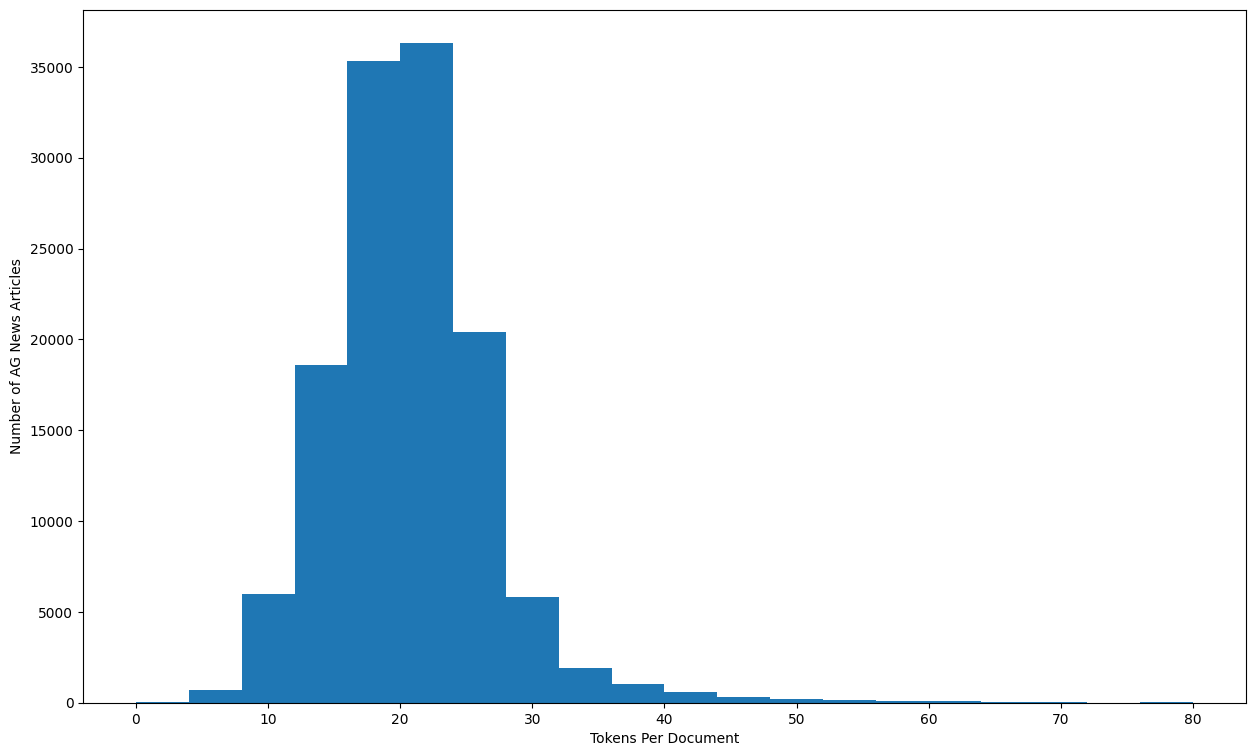

In [ ]:
plt.figure(figsize=(15,9))
plt.hist(doc_sizes, bins=20,range = (0,80))
plt.xlabel("Tokens Per Document")
plt.ylabel("Number of AG News Articles");

In [ ]:
# Time Stamp
current_time = datetime.datetime.now()
formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")

# Print the formatted time
print("Last Run:", formatted_time)

Last Run: 2024-05-01 19:01:31


In [ ]:
#Percentage of documents that have less than 30 words
n = 30
print("{0:.1%} of doc's have less than".format(sum(i <= n for i in doc_sizes)/ len(doc_sizes)), n, "words")

50.7% of doc's have less than 30 words


#Vocabulary size testing

In [ ]:
# Set vocabulary size to 1000
max_tokens = 1000
text_vectorization = TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    standardize=custom_stopwords
)
text_vectorization.adapt(text_only_dataset_all)


doc_sizes = []
corpus = []
blank_word_counts = []
for example, _ in dataset_all.as_numpy_iterator():
    enc_example = text_vectorization(example)
    doc_sizes.append(len(enc_example))
    corpus += list(enc_example.numpy())
    # Counting instances of '1', which represent OOV words
    blank_word_counts.append(np.count_nonzero(enc_example == 1))

print(f"There are {len(corpus)} words in the corpus of {len(doc_sizes)} news articles.")
print(f"Each news article has between {min(doc_sizes)} and {max(doc_sizes)} tokens in it.")
print(f"There are {len(text_vectorization.get_vocabulary())} vocabulary words in the corpus.")

vocab = np.array(text_vectorization.get_vocabulary())
print(vocab[:50])


There are 2579419 words in the corpus of 127600 news articles.
Each news article has between 2 and 95 tokens in it.
There are 1000 vocabulary words in the corpus.
['' '[UNK]' '39s' 'said' 'new' 'us' 'reuters' 'ap' 'two' 'first' 'monday'
 'wednesday' 'tuesday' 'thursday' 'company' 'friday' 'inc' 'one' 'world'
 'yesterday' 'last' 'york' 'year' 'president' 'million' 'oil' 'corp'
 'united' 'would' 'sunday' 'years' 'week' 'people' 'today' 'three'
 'government' 'could' 'quot' 'group' 'time' 'percent' 'game' 'saturday'
 'software' 'night' 'next' 'prices' 'iraq' 'security' 'announced']


In [ ]:
print(enc_example[:10])  # Print first 10 tokens of an encoded example


tf.Tensor([ 84 419 286 151 723  92 560   1   1   1], shape=(10,), dtype=int64)


Median:  48.0
Average:  48.842320375265025
42.3% of documents have more than 50% blank words.


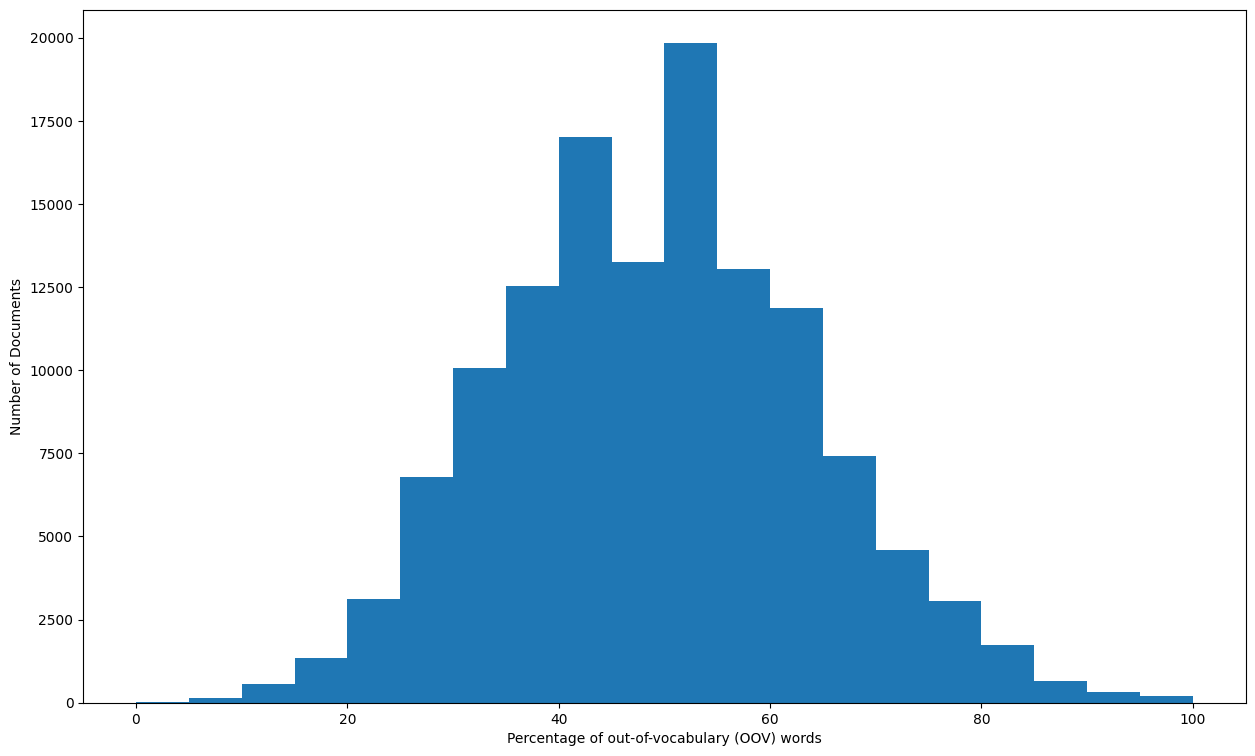

In [ ]:
# Calculate the percentage of blank words per document
percents100 = [100 * blanks / (size if size > 0 else 1) for blanks, size in zip(blank_word_counts, doc_sizes)]

# Median and average of percentage of non-vocab words per document
print("Median: ", np.median(percents100))
print("Average: ", np.average(percents100))

# Calculate the percentage of documents with more than n% blank words
n = 50
percent_documents_with_blanks = sum(p > n for p in percents100) / len(percents100) * 100
print(f"{percent_documents_with_blanks:.1f}% of documents have more than {n}% blank words.")

# Visualizing results
plt.figure(figsize=(15,9))
plt.hist(percents100, 20)
plt.ylabel('Number of Documents')
plt.xlabel('Percentage of out-of-vocabulary (OOV) words')
plt.show()

In [ ]:
# Set vocabulary size to 3000
max_tokens = 3000
text_vectorization = TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    standardize=custom_stopwords
)
text_vectorization.adapt(text_only_dataset_all)

# Collect and analyze document sizes and count blank words
doc_sizes = []
corpus = []
blank_word_counts = []
for example, _ in dataset_all.as_numpy_iterator():
    enc_example = text_vectorization(example)
    doc_sizes.append(len(enc_example))
    corpus += list(enc_example.numpy())
    # Counting instances of '1', which represent OOV words
    blank_word_counts.append(np.count_nonzero(enc_example == 1))

# Output some statistics and the first 50 vocabulary words
print(f"There are {len(corpus)} words in the corpus of {len(doc_sizes)} news articles.")
print(f"Each news article has between {min(doc_sizes)} and {max(doc_sizes)} tokens in it.")
print(f"There are {len(text_vectorization.get_vocabulary())} vocabulary words in the corpus.")
vocab = np.array(text_vectorization.get_vocabulary())
print(vocab[:50])

There are 2579419 words in the corpus of 127600 news articles.
Each news article has between 2 and 95 tokens in it.
There are 3000 vocabulary words in the corpus.
['' '[UNK]' '39s' 'said' 'new' 'us' 'reuters' 'ap' 'two' 'first' 'monday'
 'wednesday' 'tuesday' 'thursday' 'company' 'friday' 'inc' 'one' 'world'
 'yesterday' 'last' 'york' 'year' 'president' 'million' 'oil' 'corp'
 'united' 'would' 'sunday' 'years' 'week' 'people' 'today' 'three'
 'government' 'could' 'quot' 'group' 'time' 'percent' 'game' 'saturday'
 'software' 'night' 'next' 'prices' 'iraq' 'security' 'announced']


Median:  27.586206896551722
Average:  28.77622505245074
5.9% of documents have more than 50% blank words.


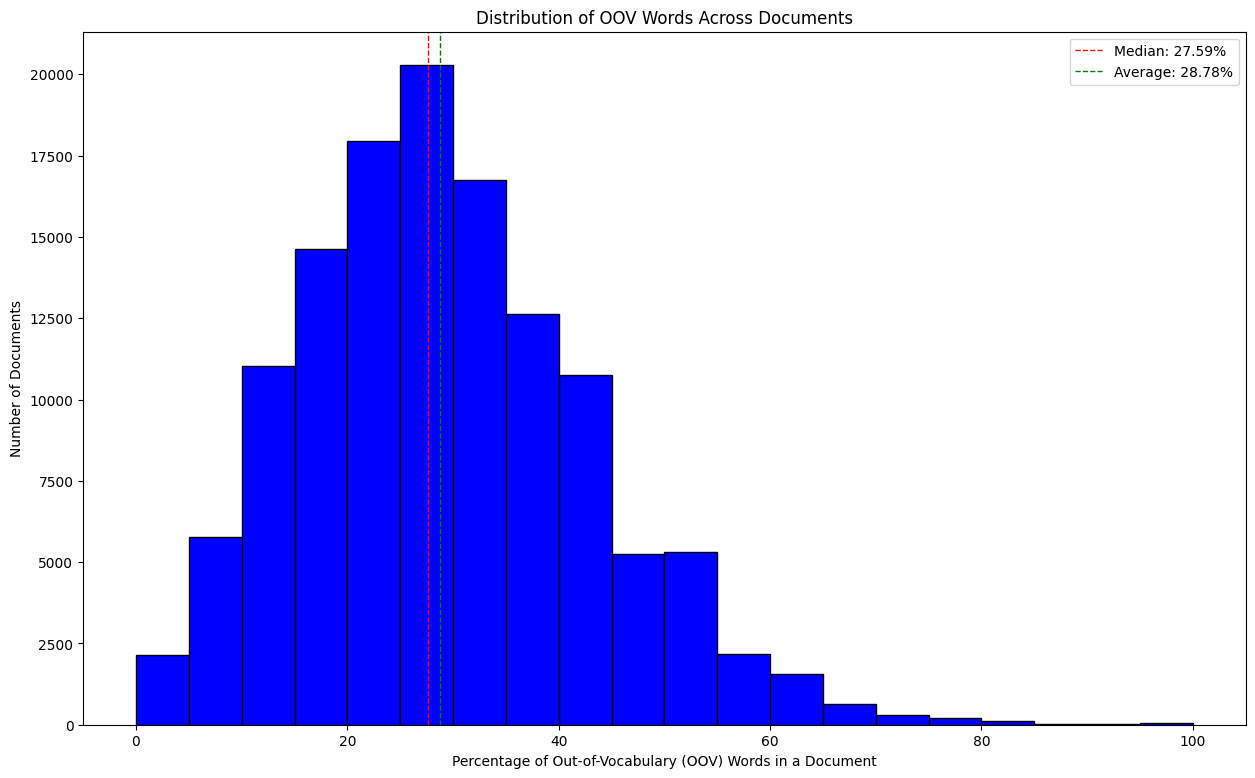

In [ ]:
# Calculate the percentage of blank words per document
percents100 = [100 * blanks / (size if size > 0 else 1) for blanks, size in zip(blank_word_counts, doc_sizes)]

# Median and average of percentage of non-vocab words per document
print("Median: ", np.median(percents100))
print("Average: ", np.average(percents100))

# Calculate the percentage of documents with more than n% blank words
n = 50
percent_documents_with_blanks = sum(p > n for p in percents100) / len(percents100) * 100
print(f"{percent_documents_with_blanks:.1f}% of documents have more than {n}% blank words.")

# Visualizing results
plt.figure(figsize=(15,9))
plt.hist(percents100, bins=20, color='blue', edgecolor='black')
plt.ylabel('Number of Documents')
plt.xlabel('Percentage of Out-of-Vocabulary (OOV) Words in a Document')
plt.title('Distribution of OOV Words Across Documents')
plt.axvline(np.median(percents100), color='red', linestyle='dashed', linewidth=1, label=f'Median: {np.median(percents100):.2f}%')
plt.axvline(np.average(percents100), color='green', linestyle='dashed', linewidth=1, label=f'Average: {np.average(percents100):.2f}%')
plt.legend()
plt.show()


In [ ]:
# Set vocabulary size to 5000
max_tokens = 5000
text_vectorization = TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    standardize=custom_stopwords
)
text_vectorization.adapt(text_only_dataset_all)

# Collect and analyze document sizes and count blank words
doc_sizes = []
corpus = []
blank_word_counts = []
for example, _ in dataset_all.as_numpy_iterator():
    enc_example = text_vectorization(example)
    doc_sizes.append(len(enc_example))
    corpus += list(enc_example.numpy())
    # Counting instances of '1', which represent OOV words
    blank_word_counts.append(np.count_nonzero(enc_example == 1))

# Output some statistics and the first 50 vocabulary words
print(f"There are {len(corpus)} words in the corpus of {len(doc_sizes)} news articles.")
print(f"Each news article has between {min(doc_sizes)} and {max(doc_sizes)} tokens in it.")
print(f"There are {len(text_vectorization.get_vocabulary())} vocabulary words in the corpus.")
vocab = np.array(text_vectorization.get_vocabulary())
print(vocab[:50])

There are 2579419 words in the corpus of 127600 news articles.
Each news article has between 2 and 95 tokens in it.
There are 5000 vocabulary words in the corpus.
['' '[UNK]' '39s' 'said' 'new' 'us' 'reuters' 'ap' 'two' 'first' 'monday'
 'wednesday' 'tuesday' 'thursday' 'company' 'friday' 'inc' 'one' 'world'
 'yesterday' 'last' 'york' 'year' 'president' 'million' 'oil' 'corp'
 'united' 'would' 'sunday' 'years' 'week' 'people' 'today' 'three'
 'government' 'could' 'quot' 'group' 'time' 'percent' 'game' 'saturday'
 'software' 'night' 'next' 'prices' 'iraq' 'security' 'announced']


Median:  18.75
Average:  20.409266045192187
1.6% of documents have more than 50% blank words.


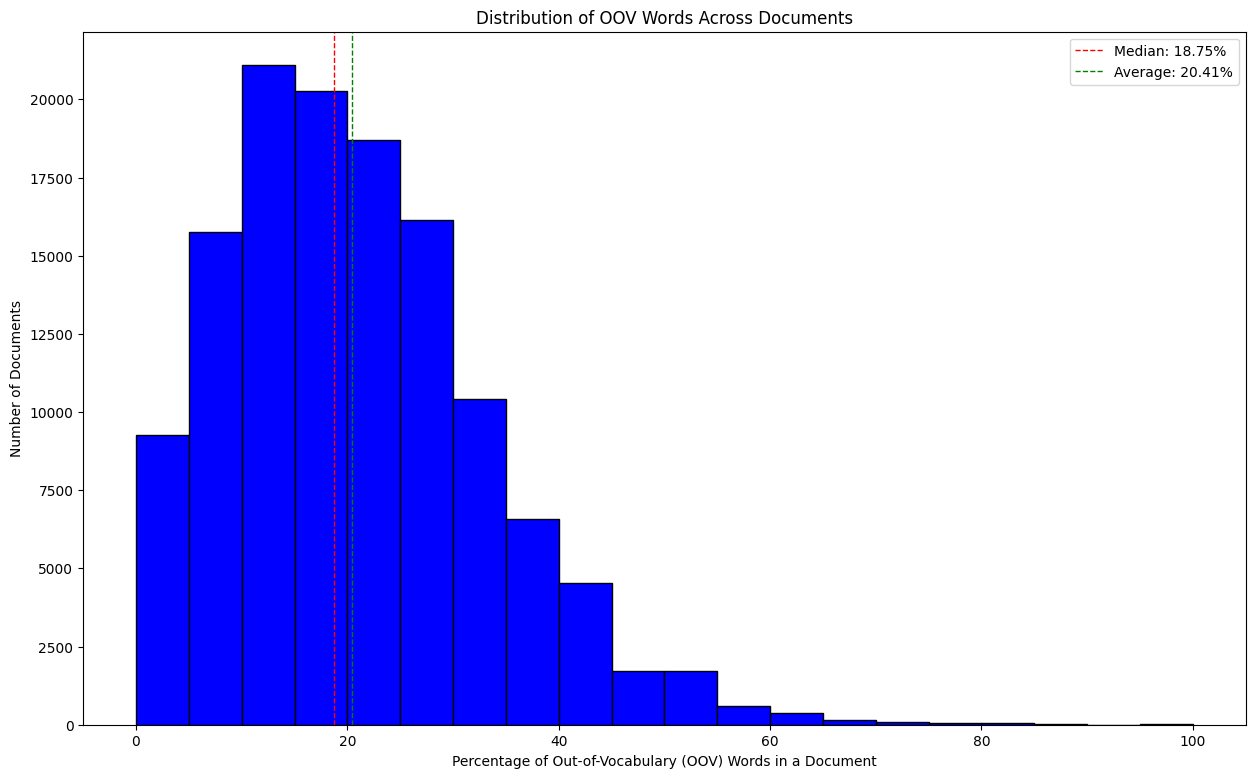

In [ ]:
# Calculate the percentage of blank words per document
percents100 = [100 * blanks / (size if size > 0 else 1) for blanks, size in zip(blank_word_counts, doc_sizes)]

# Median and average of percentage of non-vocab words per document
print("Median: ", np.median(percents100))
print("Average: ", np.average(percents100))

# Calculate the percentage of documents with more than n% blank words
n = 50
percent_documents_with_blanks = sum(p > n for p in percents100) / len(percents100) * 100
print(f"{percent_documents_with_blanks:.1f}% of documents have more than {n}% blank words.")

# Visualizing results
plt.figure(figsize=(15,9))
plt.hist(percents100, bins=20, color='blue', edgecolor='black')
plt.ylabel('Number of Documents')
plt.xlabel('Percentage of Out-of-Vocabulary (OOV) Words in a Document')
plt.title('Distribution of OOV Words Across Documents')
plt.axvline(np.median(percents100), color='red', linestyle='dashed', linewidth=1, label=f'Median: {np.median(percents100):.2f}%')
plt.axvline(np.average(percents100), color='green', linestyle='dashed', linewidth=1, label=f'Average: {np.average(percents100):.2f}%')
plt.legend()
plt.show()